In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg
!pip install scikit-misc

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
import re

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.scDEED as scd
import BacSC.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
import gzip
import shutil
data_dir = "../../data/BacDrop/raw_data/"
file_names = ["GSM5456506_Kp_CDS.tsv"]

for f in file_names:
    file_name_full = data_dir + f

    if not f in os.listdir(data_dir):
        if f + ".gz" in os.listdir(data_dir):
            print("unzipping data...")
            with gzip.open(file_name_full + ".gz","rb") as f_in, open(file_name_full,"wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
        else:
            raise FileNotFoundError(f"{f} does not exist in regular or zipped form")

In [5]:
adatas = []
for f in file_names:
    file_name_full = data_dir + f
    print(f)
    adata = sc.read_csv(file_name_full, delimiter="\t", first_column_names=True)
    adata = adata.transpose()
    adata.var_names_make_unique()
    adata.X = sps.csr_matrix(adata.X)
    adatas.append(adata)
    
adatas

GSM5456506_Kp_CDS.tsv


[AnnData object with n_obs × n_vars = 8648 × 4539]

In [6]:
adatas[0].obs["species"] = "K.pneumoniae"


In [7]:
data_untr = adatas[0]
data_untr

AnnData object with n_obs × n_vars = 8648 × 4539
    obs: 'species'

In [8]:
print(f"Zero inflation of data: {((np.prod(data_untr.X.shape) - data_untr.X.getnnz()) / np.prod(data_untr.X.shape)).round(3)}")


Zero inflation of data: 0.999


### Filter cells

--> filter based on mean absolute standard deviation

In [9]:
importlib.reload(ut)
data_gene = data_untr.copy()
# sc.pp.filter_cells(data_gene, min_genes=15)
# sc.pp.filter_genes(data_gene, min_cells=2)
# sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)

data_gene = ut.filter_outliers(data_untr, nmads=10, min_cells=2, min_genes=15)
# print(data_untr.obs.outlier.value_counts())
print(f"Total number of cells: {data_untr.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Total number of cells: 8648
Number of cells after filtering: 315


AnnData object with n_obs × n_vars = 315 × 1265
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [10]:
print(data_gene.obs["species"].value_counts())

K.pneumoniae    315
Name: species, dtype: int64


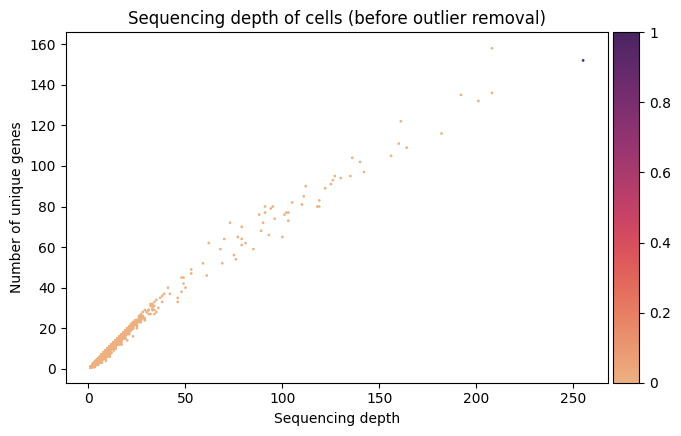

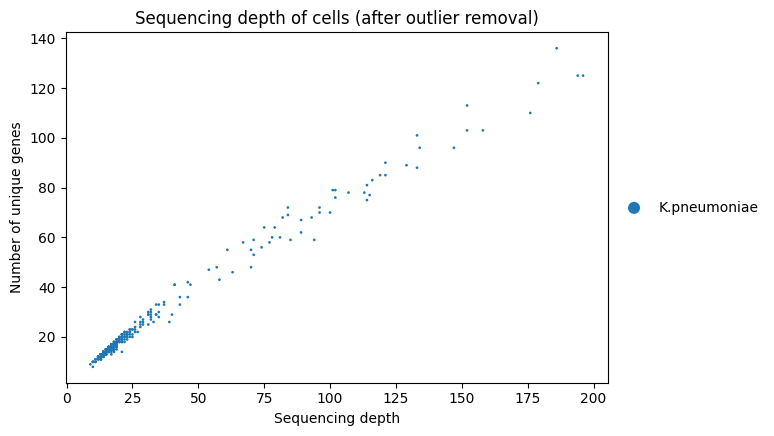

In [11]:
g = sc.pl.scatter(data_untr, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="species")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [12]:
data_gene.layers["counts"] = data_gene.X.copy()

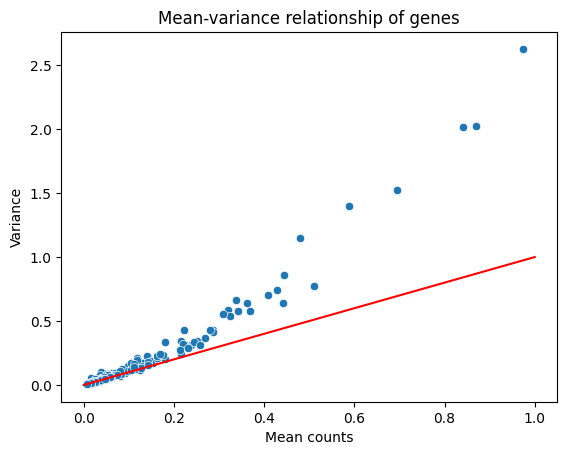

In [13]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [14]:
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
print(is_overdispersed)

False


## Estimate negative binomial parameters for each gene

In [15]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=1234)

In [16]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,0.672014,-7.583337,2.189062,-5.726996,1.095236,0.006570
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,0.360850,-7.082745,1.065713,-9.013648,2.556335,0.005360
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,0.465988,-7.759450,1.882000,-4.929424,0.197285,0.006152
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,0.360850,-7.082745,1.065713,-7.843096,1.860073,0.010406
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,0.465988,-7.759450,1.882000,-8.485802,2.485612,0.006486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,0.465988,-7.759450,1.882000,-8.344090,2.403147,0.004565
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,0.672014,-7.583337,2.189062,-6.796970,1.779938,0.006532
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,0.465988,-7.759450,1.882000,-6.999384,1.587081,0.008965
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,0.672014,-7.583337,2.189062,-4.721270,0.410855,0.006153


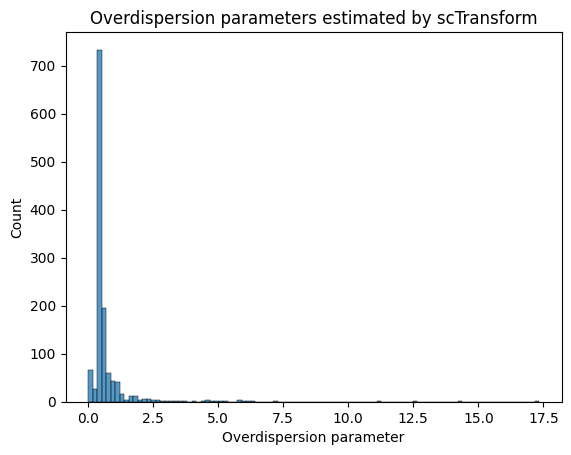

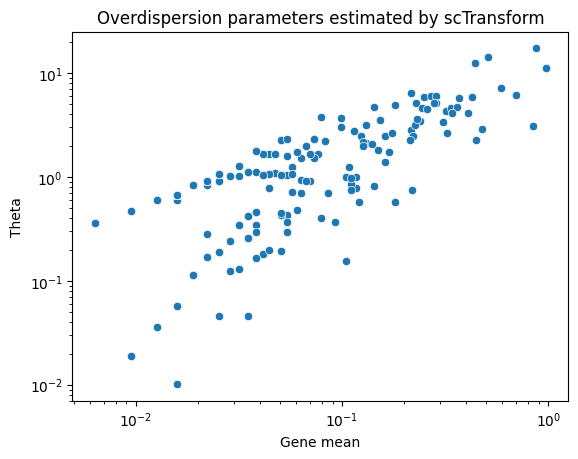

In [17]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [18]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [19]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.pp.highly_variable_genes(data_gene, n_top_genes=2000, flavor="seurat_v3", layer="counts", span=1)
data_gene = data_gene[:, data_gene.var.highly_variable]
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

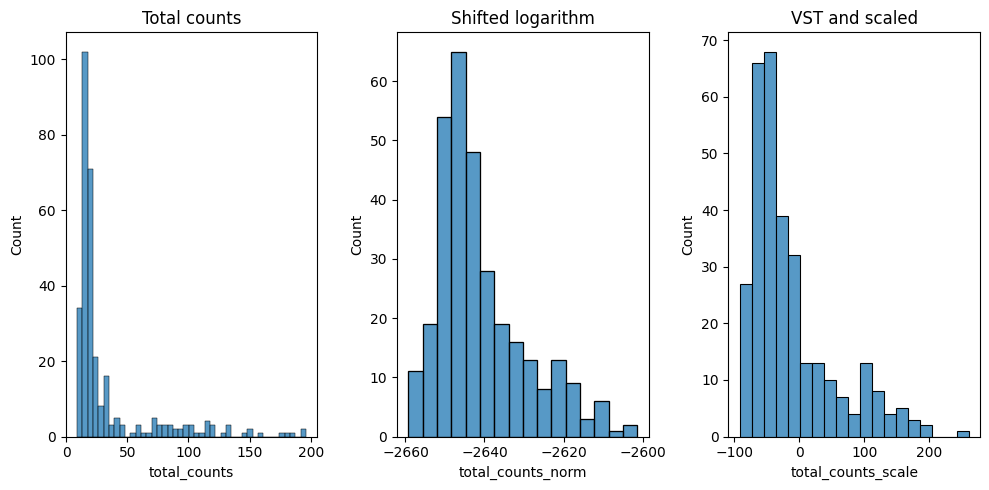

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [21]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 315 × 398
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'counts'


In [22]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

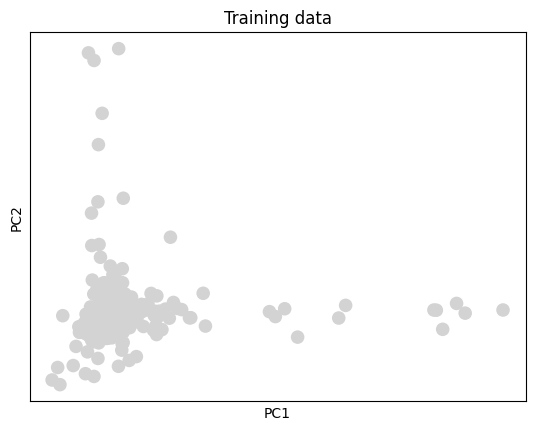

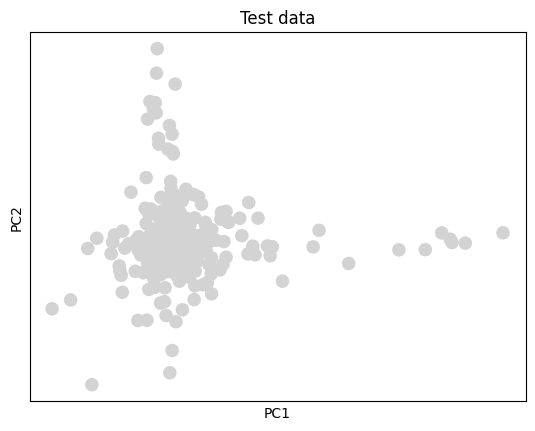

In [23]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

In [24]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:4


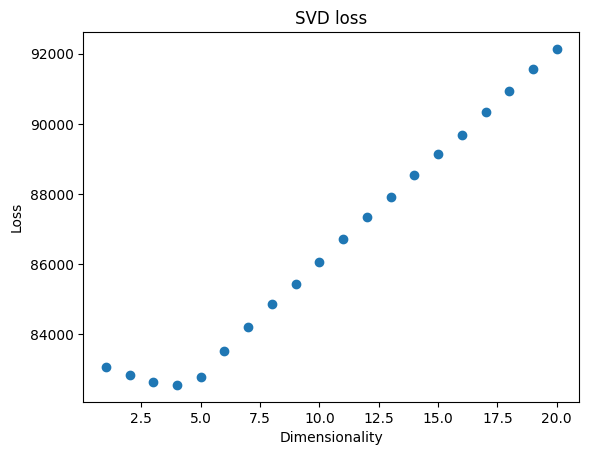

In [25]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

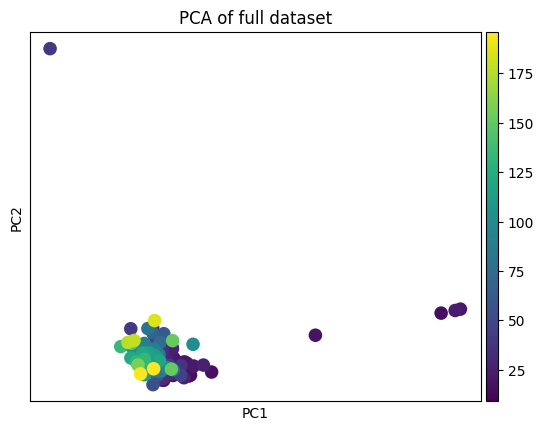

In [26]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

In [27]:
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [28]:
rng = np.random.default_rng()
seed = rng.choice(1000)
print(seed)

976


In [29]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="Klebsiella_4species_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 10
Optimal min_dist: 0.7


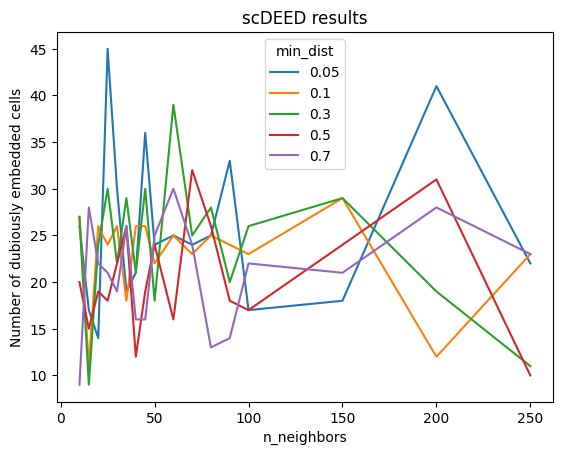

In [30]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [31]:
# k_opt = data_gene.uns["BacSC_params"]["k_opt"]
# n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
# min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]


# k_opt = 4
# n_neighbors_opt = 30
# min_dist_opt = 0.3
print(k_opt)

4


In [32]:
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

In [33]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


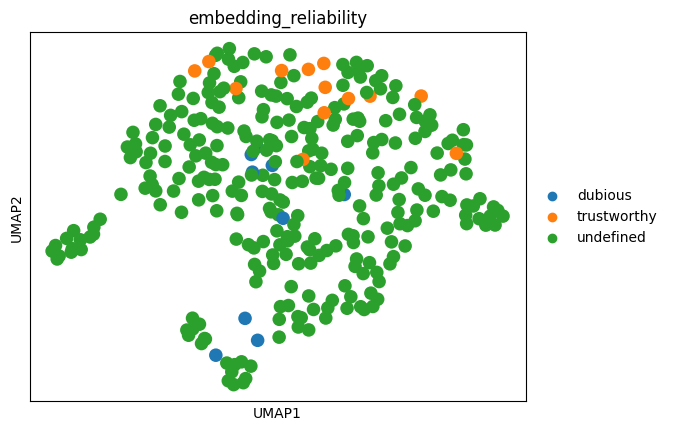

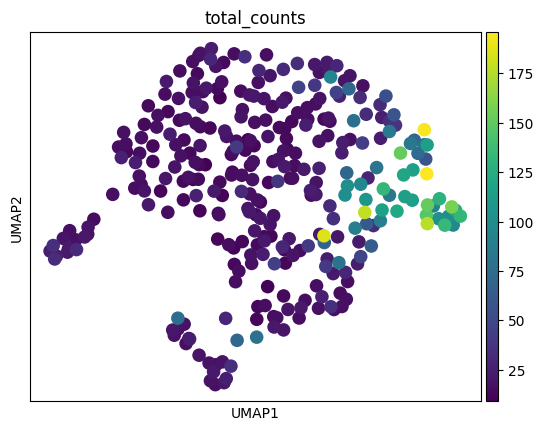

In [34]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [35]:
data_path = "../../data/BacDrop"

data_gene.write(data_path + "/klebsiella_4species_data_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [36]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

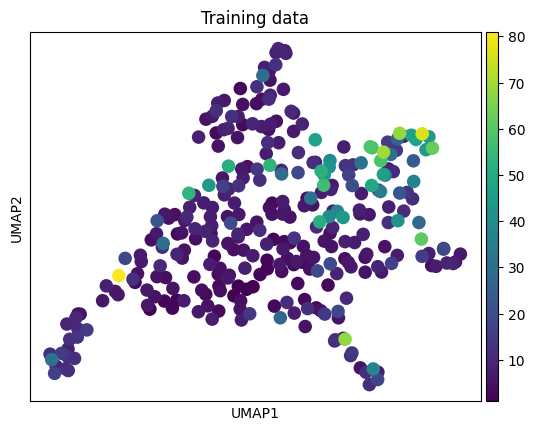

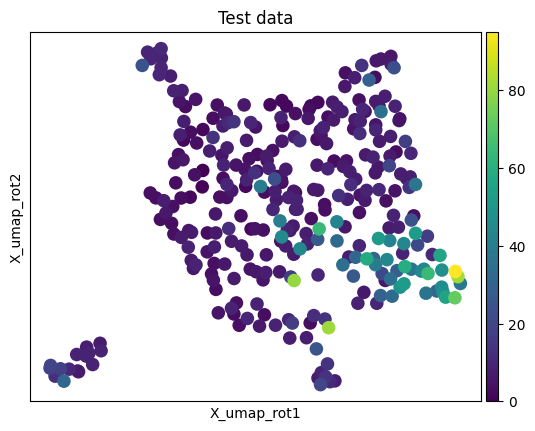

In [37]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [38]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=1234)

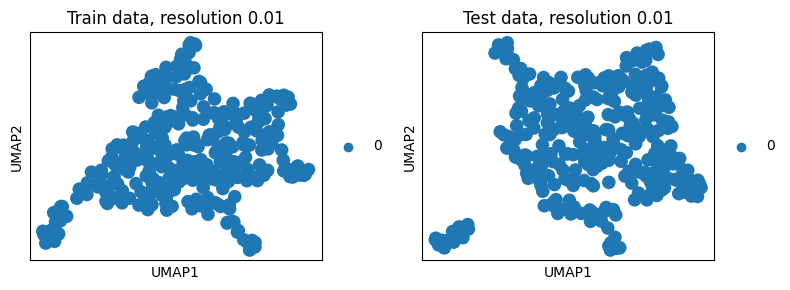

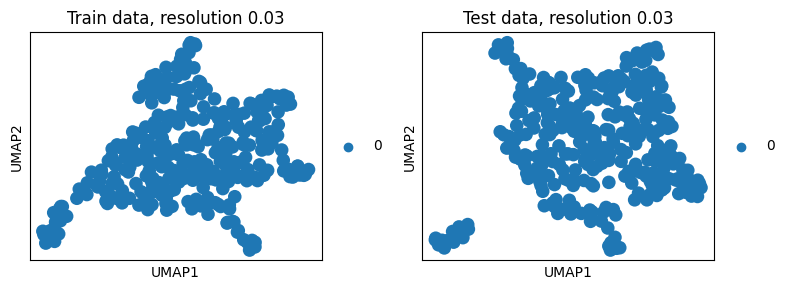

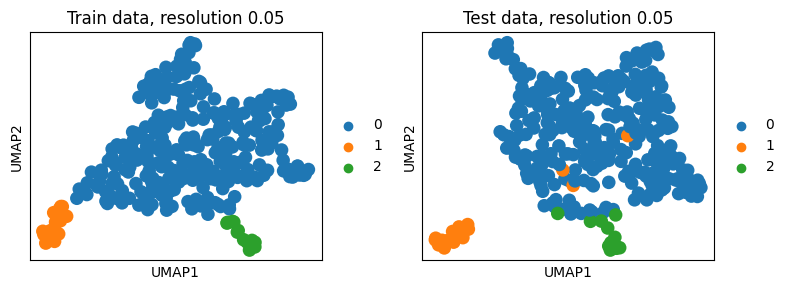

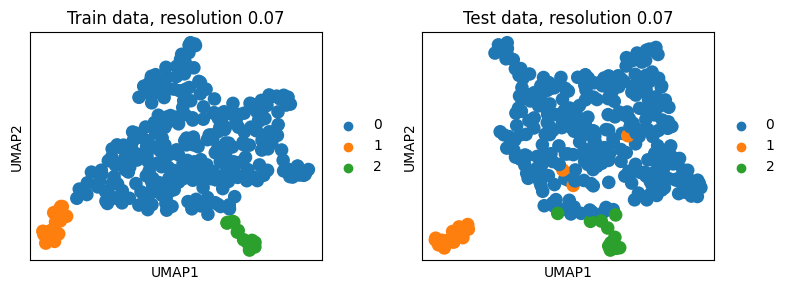

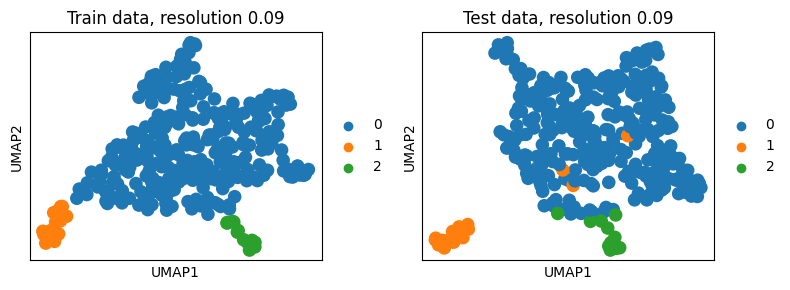

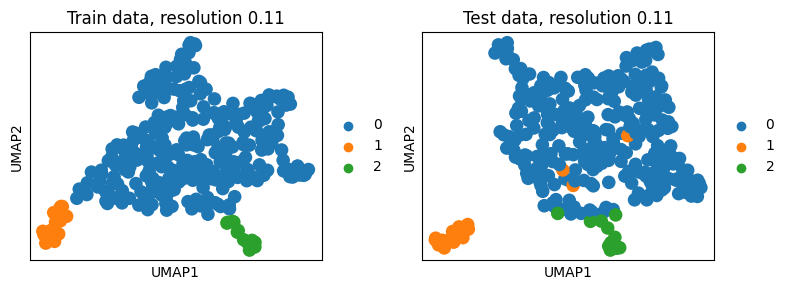

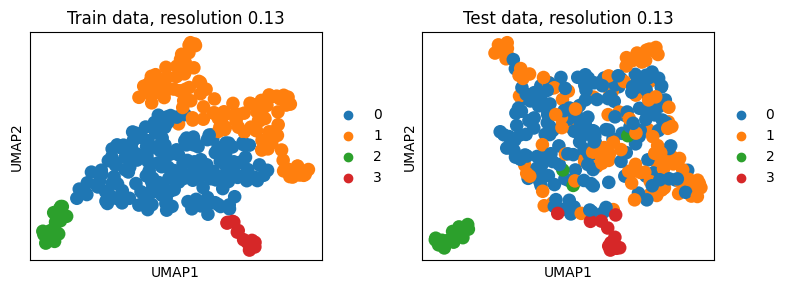

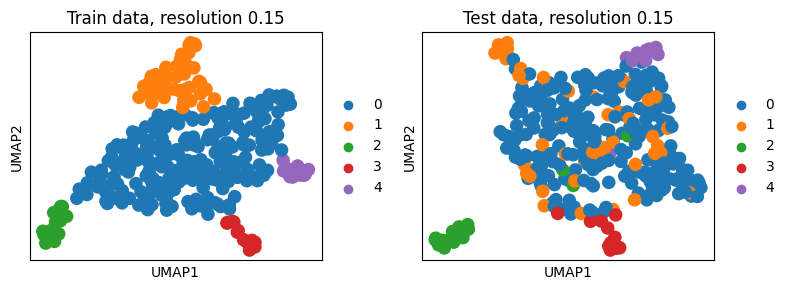

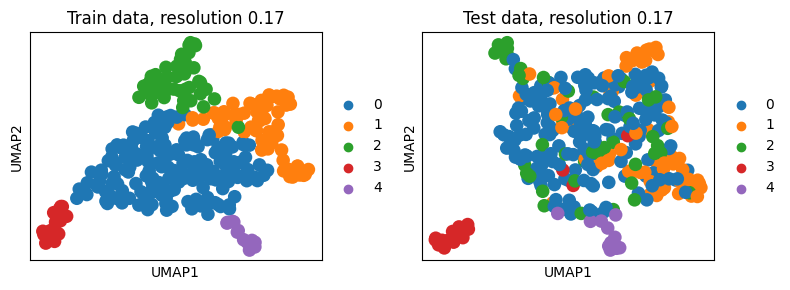

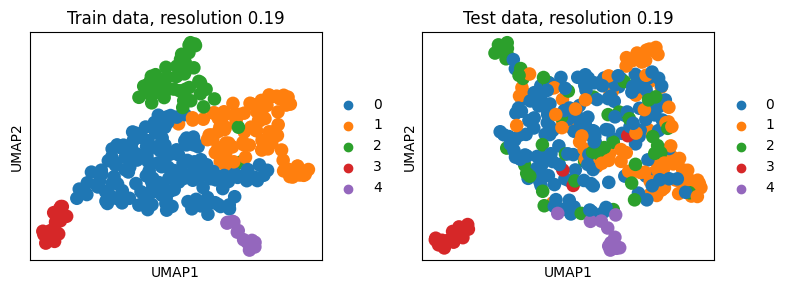

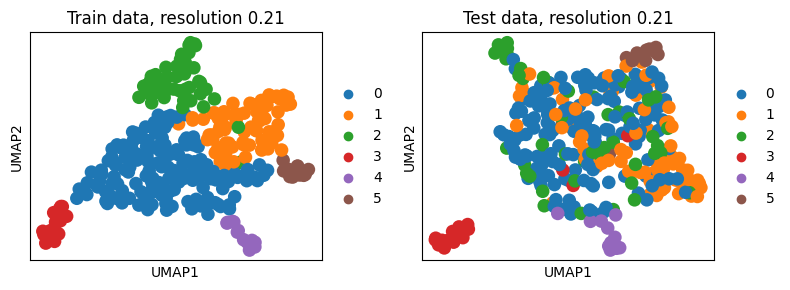

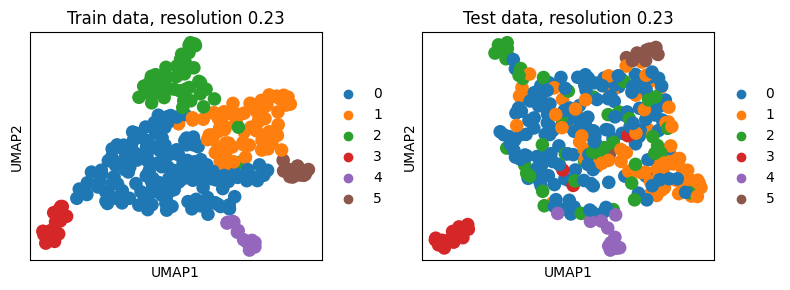

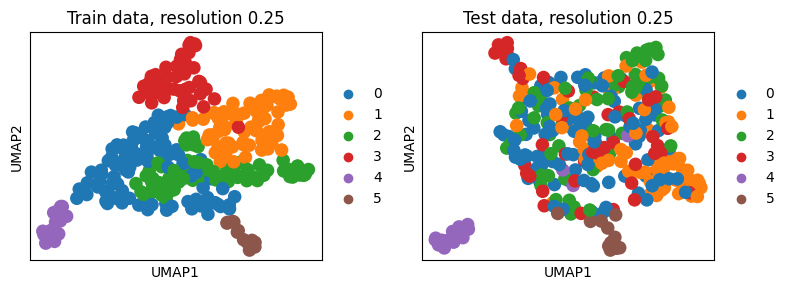

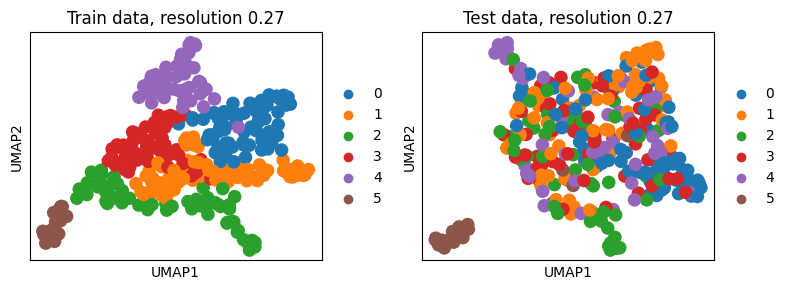

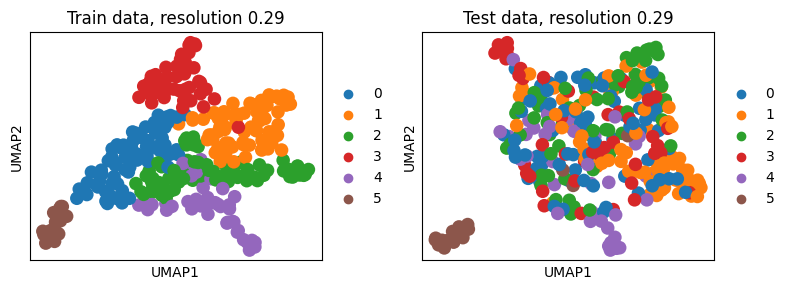

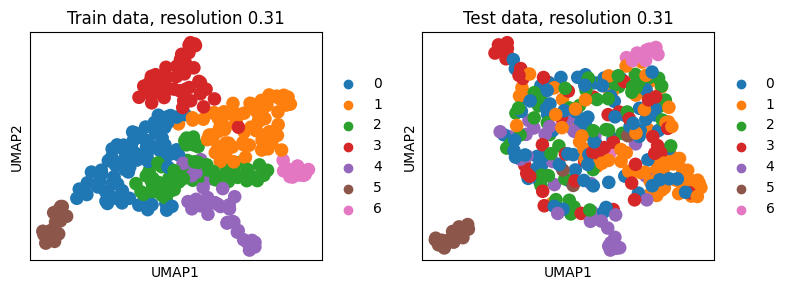

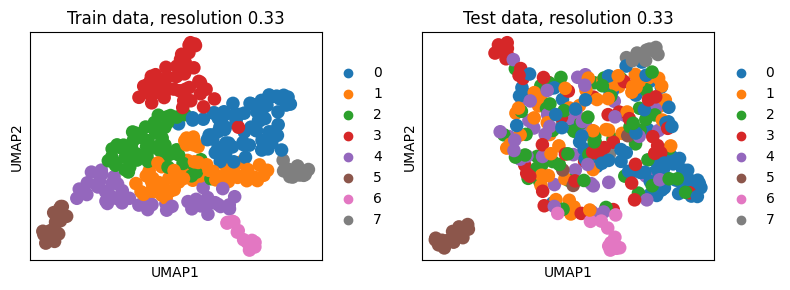

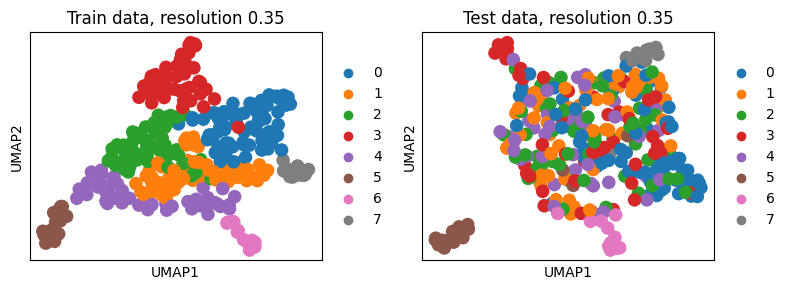

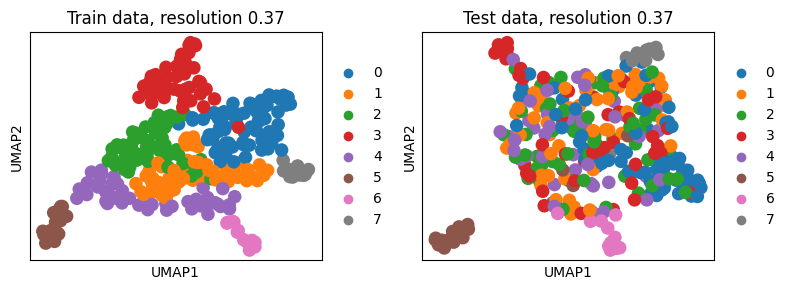

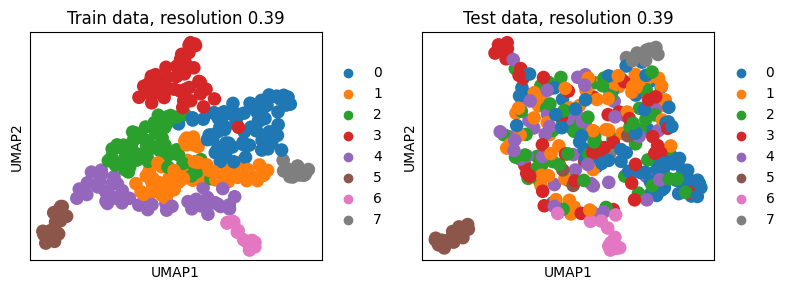

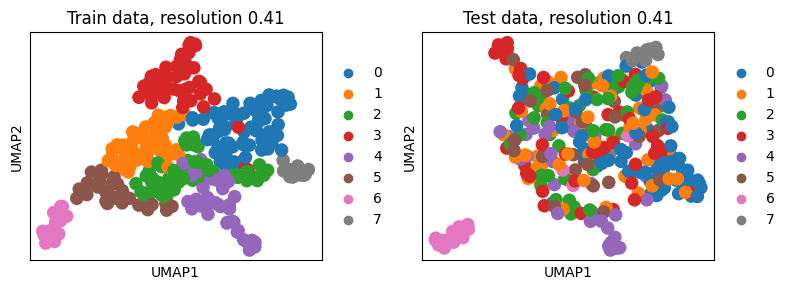

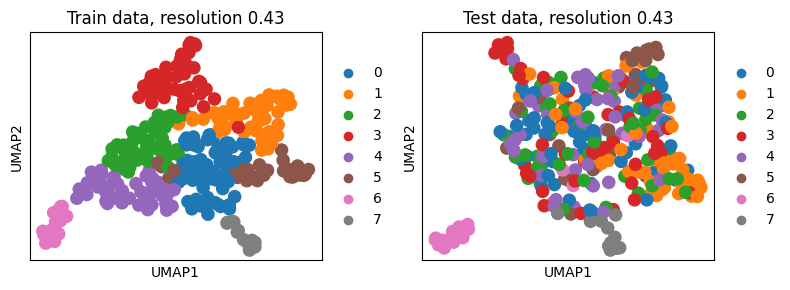

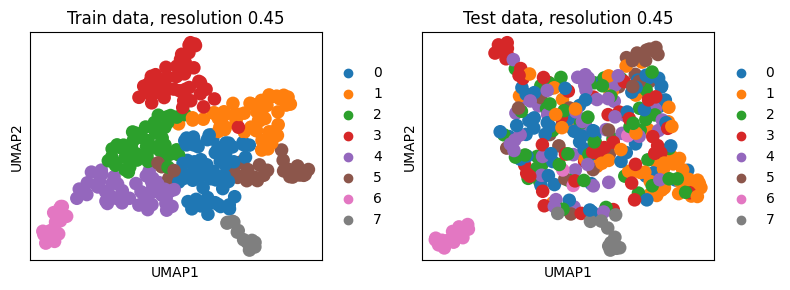

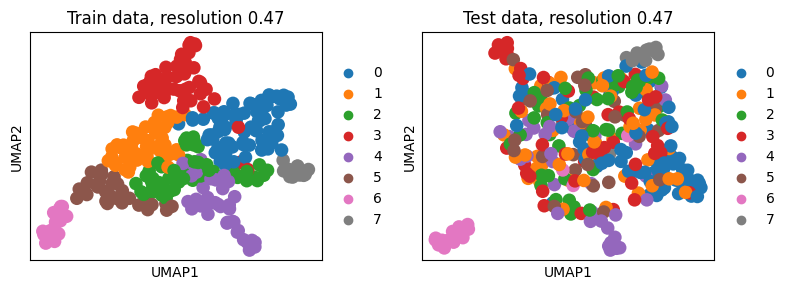

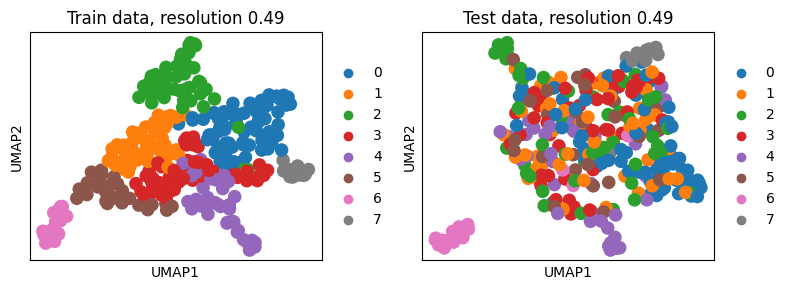

In [39]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Modularities

In [40]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 3 - Train: 0.45 - Test: 0.438 - Random: 0.372
resolution: 0.07 - clusters: 3 - Train: 0.433 - Test: 0.422 - Random: 0.353
resolution: 0.09 - clusters: 3 - Train: 0.416 - Test: 0.405 - Random: 0.338
resolution: 0.11 - clusters: 3 - Train: 0.399 - Test: 0.388 - Random: 0.324
resolution: 0.13 - clusters: 4 - Train: 0.4 - Test: 0.246 - Random: 0.158
resolution: 0.15 - clusters: 5 - Train: 0.385 - Test: 0.281 - Random: 0.189
resolution: 0.17 - clusters: 5 - Train: 0.389 - Test: 0.214 - Random: 0.121
resolution: 0.19 - clusters: 5 - Train: 0.384 - Test: 0.196 - Random: 0.107
resolution: 0.21 - clusters: 6 - Train: 0.378 - Test: 0.187 - Random: 0.086
resolution: 0.23 - clusters: 6 - Train: 0.372 - Test: 0.18 - Random: 0.087
resolution: 0.25 - clusters: 6 - Train: 0.372 - Test: 0.134 - Random: 0.066
resolution: 0.27 - clu

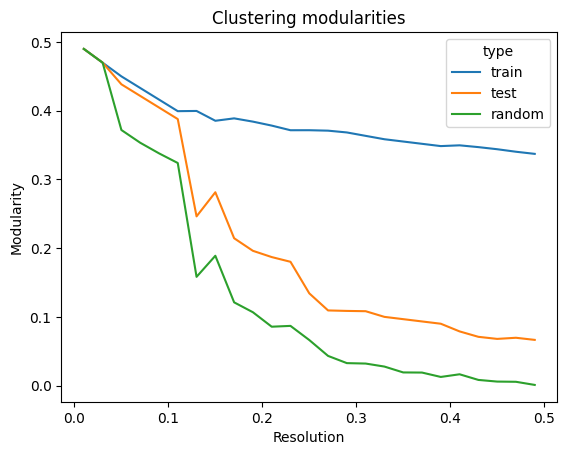

In [41]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

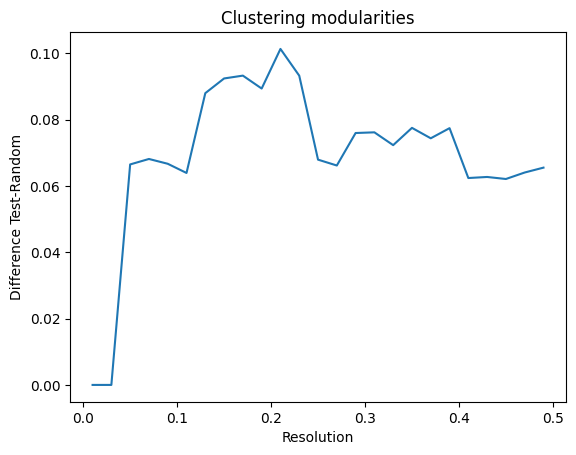

In [42]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [43]:
result_path = "Klebsiella_4species_clustering"
if not os.path.exists(result_path):
    os.makedirs(result_path)
    
mod_df.to_csv(result_path + "/modularities.csv")
mod_df_wide.to_csv(result_path + "/modularities_wide.csv")

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [44]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

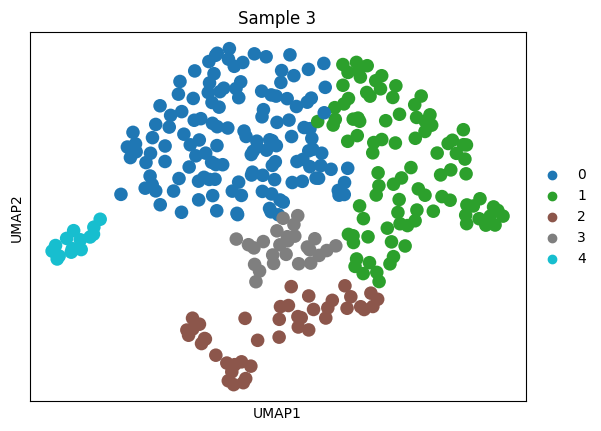

In [45]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [46]:
data_gene.write(data_path + "/klebsiella_4species_data_processed.h5ad")

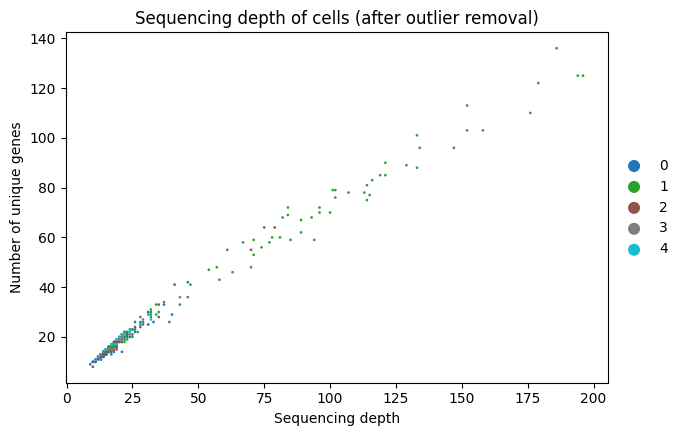

In [47]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

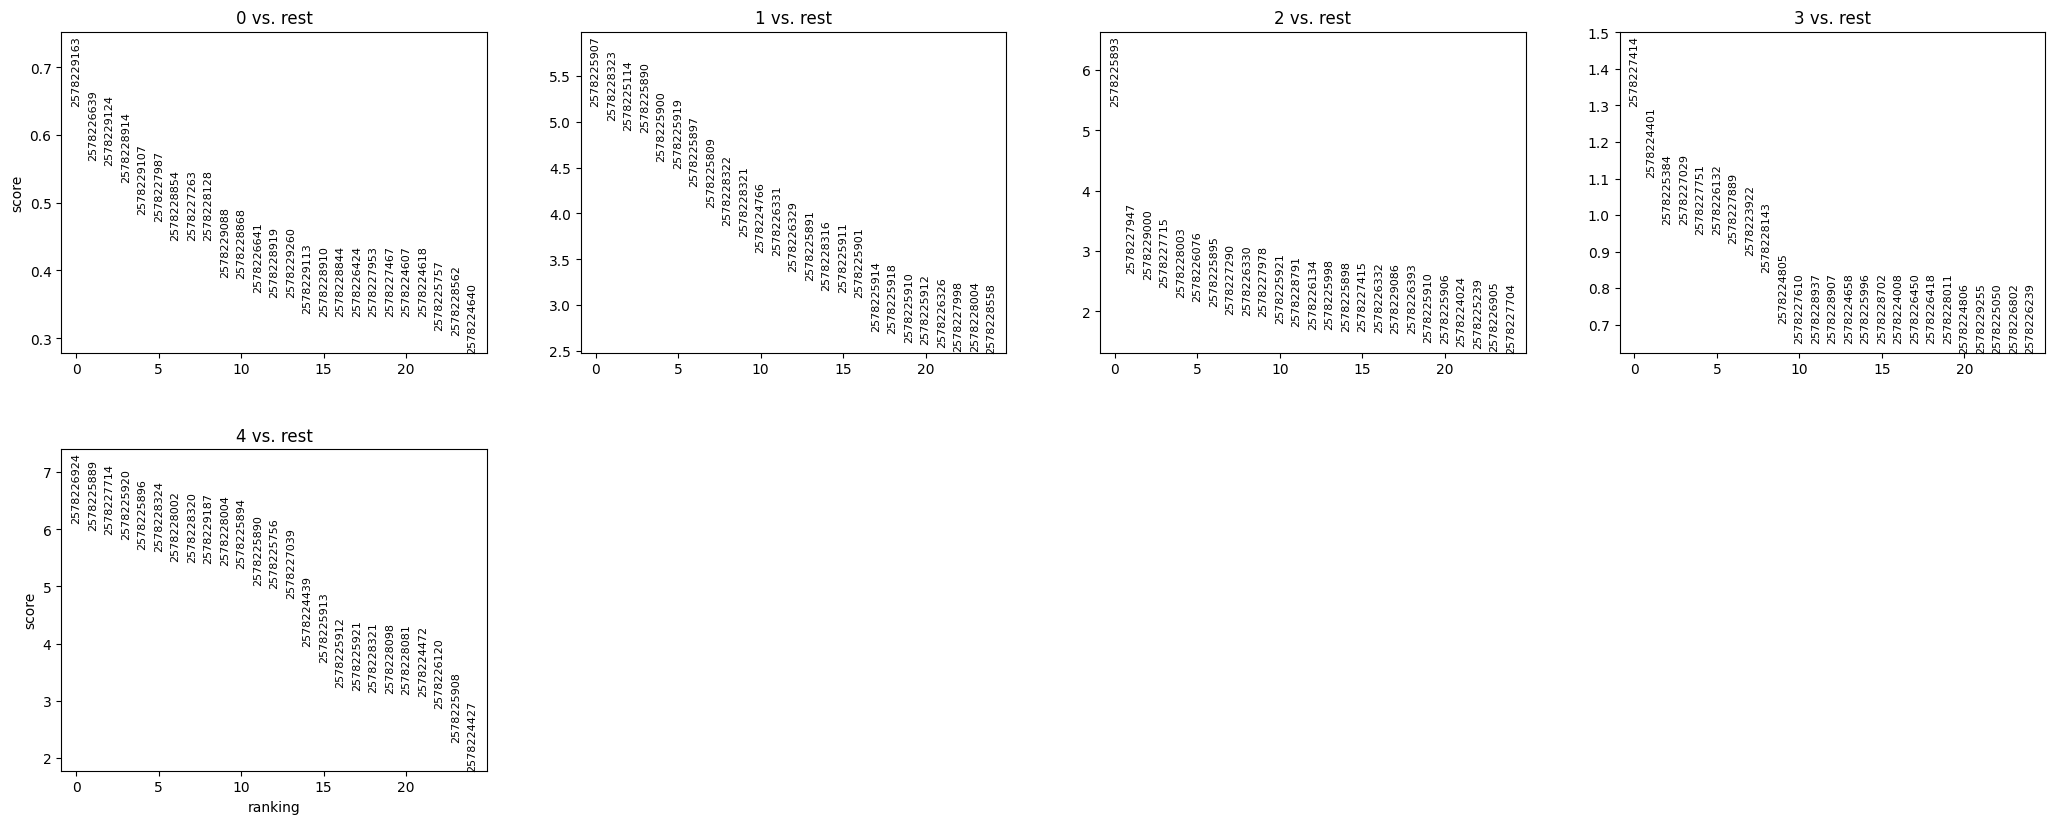

In [48]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

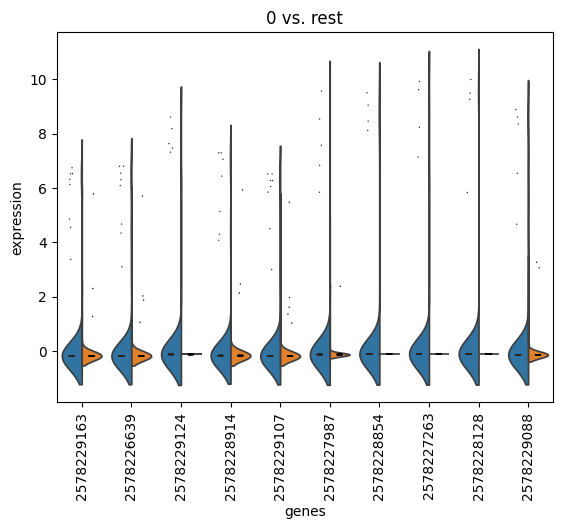

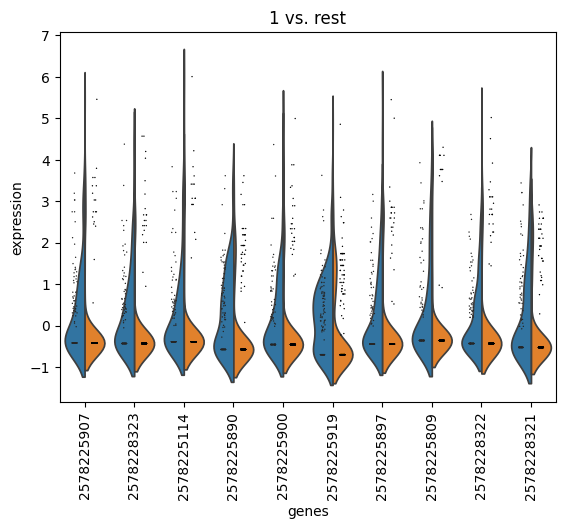

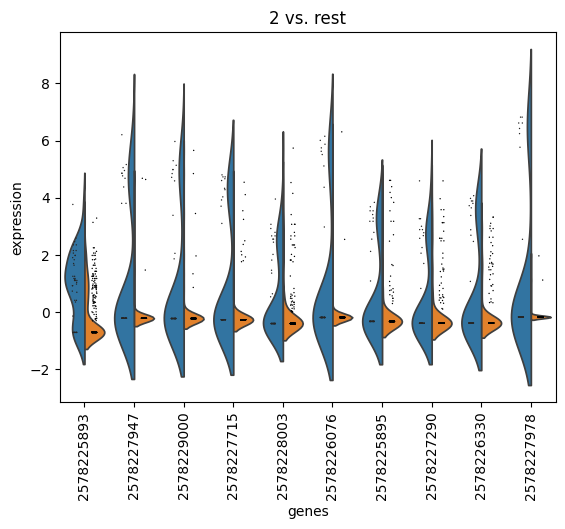

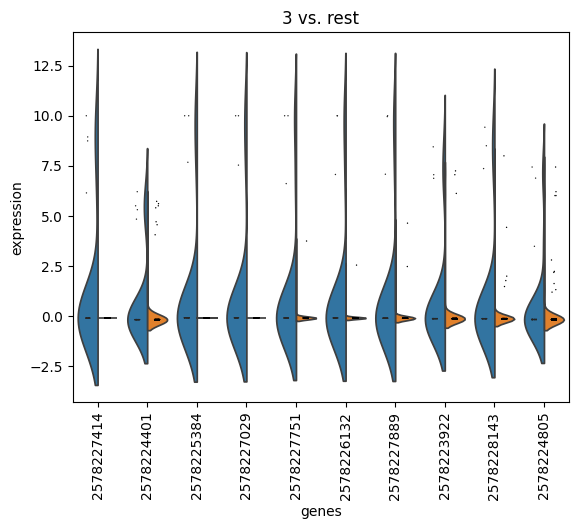

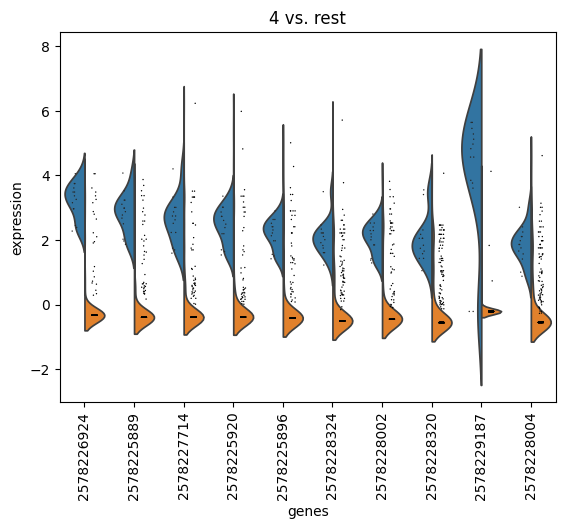

In [49]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)

## Attach feature table

In [50]:
data_path = "../../data/BacDrop/"
data_gene = sc.read_h5ad(data_path + "/klebsiella_4species_data_processed.h5ad")
data_gene

AnnData object with n_obs × n_vars = 315 × 1265
    obs: 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'BacSC_params', 'embedding_reliability_colors', 'hvg', 'leiden_opt', 'leiden_opt_colors', 'neighbors', 'pca', 'species_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'connectivities', 'distances'

In [51]:
feature_table = pd.read_csv(data_path + "genomic_information/klebsiella_MGH66/GCF_000694555.1_Kleb_pneu_MGH_66_V1_feature_table.txt", sep="\t")
feature_table = feature_table[feature_table["# feature"] == "CDS"][["locus_tag", "product_accession", "name", "symbol"]]

feature_table

,locus_tag,product_accession,name,symbol
1,AF52_RS22895,WP_228690219.1,restriction endonuclease,NaN
3,AF52_RS22890,NaN,IS5/IS1182 family transposase,NaN
5,AF52_RS26590,NaN,IS5/IS1182 family transposase,NaN
7,AF52_RS26600,NaN,IS5/IS1182 family transposase,NaN
9,AF52_RS0122900,NaN,exonuclease,NaN
...,...,...,...,...
9857,AF52_RS00020,WP_021441167.1,two-component system sensor histidine kinase CreC,creC
9859,AF52_RS00015,WP_004214415.1,cell envelope integrity protein CreD,creD
9861,AF52_RS00010,WP_002887843.1,two-component system response regulator ArcA,arcA
9863,AF52_RS27685,WP_004146984.1,hypothetical protein,NaN


In [52]:
ind = data_gene.var.index

data_gene.var["lt"] = [x.removeprefix('cds-') for x in data_gene.var.index]
data_gene.var["lt"] = [re.sub(r"-[0-9]+", "", x) for x in data_gene.var["lt"]]
# data_gene.var.drop(columns=["locus_tag", "product_accession", "name", "symbol"], inplace=True)

df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='locus_tag', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df4=data_gene.var.reset_index().merge(feature_table, how='left', left_on='lt', right_on='product_accession', suffixes=(None, "_y")).drop_duplicates("index").set_index("index")
df5 = pd.merge(df3, df4, how="outer", left_index=True, right_index=True, suffixes=(None, "_y"))

df5.locus_tag.fillna(df5.locus_tag_y, inplace=True)
df5.product_accession.fillna(df5.product_accession_y, inplace=True)
df5.name.fillna(df5.name_y, inplace=True)
df5.symbol.fillna(df5.symbol_y, inplace=True)

df5 = df5.loc[:,~df5.columns.str.endswith('_y')]

mdf = data_gene.var.merge(df5, how="left", left_index=True, right_index=True, suffixes=(None, "_y"))
mdf = mdf.loc[:,~mdf.columns.str.endswith('_y')]
data_gene.var
data_gene.var = mdf

In [53]:
data_gene.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,...,highly_variable,highly_variable_rank,means,variances,variances_norm,lt,locus_tag,product_accession,name,symbol
2578223750,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,True,1053.0,0.015873,0.015671,0.942789,2578223750,NaN,NaN,NaN,NaN
2578223780,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,True,344.0,0.006349,0.006329,0.997624,2578223780,NaN,NaN,NaN,NaN
2578223790,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,True,663.0,0.009524,0.009463,0.976885,2578223790,NaN,NaN,NaN,NaN
2578223794,2,0.006349,0.006329,99.365079,2.0,1.098612,2,0.006309,False,0.360850,...,True,342.0,0.006349,0.006329,0.997624,2578223794,NaN,NaN,NaN,NaN
2578223796,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,True,665.0,0.009524,0.009463,0.976885,2578223796,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578229255,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,True,727.0,0.009524,0.009463,0.976885,2578229255,NaN,NaN,NaN,NaN
2578229258,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,True,1009.0,0.015873,0.015671,0.942789,2578229258,NaN,NaN,NaN,NaN
2578229259,3,0.009524,0.009479,99.047619,3.0,1.386294,3,0.009433,False,0.465988,...,True,680.0,0.009524,0.009463,0.976885,2578229259,NaN,NaN,NaN,NaN
2578229260,5,0.015873,0.015748,98.412698,5.0,1.791759,5,0.015621,False,0.672014,...,True,1061.0,0.015873,0.015671,0.942789,2578229260,NaN,NaN,NaN,NaN


In [54]:
data_gene.write(data_path + "/klebsiella_4species_data_processed.h5ad")